In [1]:
#import statements

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

import os

import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.metrics import roc_curve, auc, RocCurveDisplay

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import utils
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import backend as K



# the size of the images in the PCAM dataset
IMAGE_SIZE = 96

In [127]:
#get data from patchCAMELYON dataset (from Constantijn)

def get_pcam_generators(base_dir, train_batch_size=64, val_batch_size=64, class_mode='binary', ae_model=None):

     # dataset parameters
     TRAIN_PATH = os.path.join(base_dir, 'train+val', 'train')
     VALID_PATH = os.path.join(base_dir, 'train+val', 'valid')

     RESCALING_FACTOR = 1./255

     if ae_model is not None:
          ae_model = model_transform(ae_model).model_transform

     # instantiate data generators
     datagen = ImageDataGenerator(rescale=RESCALING_FACTOR, preprocessing_function=ae_model)

     train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=train_batch_size,
                                             class_mode=class_mode, 
                                             shuffle=False
                                             )


     val_gen = datagen.flow_from_directory(VALID_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=val_batch_size,
                                             class_mode=class_mode,
                                             shuffle=False)
     
     return train_gen, val_gen

class model_transform:
     def __init__(self, ae_model_1):
          self.ae_model_1 = ae_model_1

     def model_transform(self, tensor):
          tensor_adjusted = utils.img_to_array(tensor)
          tensor_adjusted = np.array([tensor_adjusted])
          tensor_adjusted_prediction = self.ae_model_1.predict(tensor_adjusted/255, verbose=None)[0]
          return tensor_adjusted_prediction*255

In [128]:
train_gen, val_gen = get_pcam_generators('C:/Users/20212238/OneDrive - TU Eindhoven/Documents/TUE/Jaar 3/Project AI MIA', class_mode='input')
train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [4]:
#autoencoder (from Constantijn)

class autoencoder(Sequential):
    def __init__(self):
        super().__init__()
        self.add(Input(shape=(96,96,3)))

    def create_autoencoder_v1(self, layers = 1):
        for i in range(layers):
            self.add(Conv2D(64, (3,3), activation='relu', padding='same'))
            self.add(MaxPool2D((2,2), padding='same'))

            self.add(Conv2D(32, (3,3), activation='relu', padding='same'))
            self.add(MaxPool2D((2,2), padding='same'))

            self.add(Conv2D(32, (3,3), activation='relu', padding='same'))
            self.add(MaxPool2D((2,2), padding='same'))

            self.add(Conv2D(32, (3,3), activation='relu', padding='same'))
            self.add(UpSampling2D((2,2)))

            self.add(Conv2D(32, (3,3), activation='relu', padding='same'))
            self.add(UpSampling2D((2,2)))
            
            self.add(Conv2D(64, (3,3), activation='relu', padding='same'))
            self.add(UpSampling2D((2,2)))

    def create_autoencoder_v2(self, layers = 1):
        for i in range(layers):
            self.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(96,96,3)))
            self.add(MaxPool2D((2,2), padding='same'))
        
            self.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(96,96,3), name='encoder'))
            self.add(MaxPool2D((2,2), padding='same'))

            self.add(Conv2DTranspose(64, (3,3),strides=2 ,activation='relu', padding='same'))
            self.add(Conv2DTranspose(64, (3,3),strides=2 ,activation='relu', padding='same'))


    def compile_model(self):
        self.add(Conv2D(3, (3,3), activation='sigmoid', padding='same'))
        self.compile(optimizer='adam', loss='mean_squared_error')
    
model1 = autoencoder()
model1.create_autoencoder_v2()
model1.compile_model()
model1._name = 'model1'

In [7]:
# save the model and weights
model_name = 'my_first_cnn_model'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model1.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 


# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]


# train the model
train_steps = train_gen.n//train_gen.batch_size//2
val_steps = val_gen.n//val_gen.batch_size//2

history = model1.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=1,
                    shuffle=True,
                    callbacks=callbacks_list)

model1.save('model1.h5')

4500/4500 [==============================] - ETA: 0s - loss: 0.0078
Epoch 1: val_loss improved from inf to 0.00584, saving model to my_first_cnn_model_weights.hdf5
4500/4500 [==============================] - 1439s 320ms/step - loss: 0.0078 - val_loss: 0.0058


C:\Users\20212238\.conda\envs\project8p361\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [129]:
train_gen_fake, val_gen_fake = get_pcam_generators('C:/Users/20212238/OneDrive - TU Eindhoven/Documents/TUE/Jaar 3/Project AI MIA', class_mode="binary", ae_model=model1)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


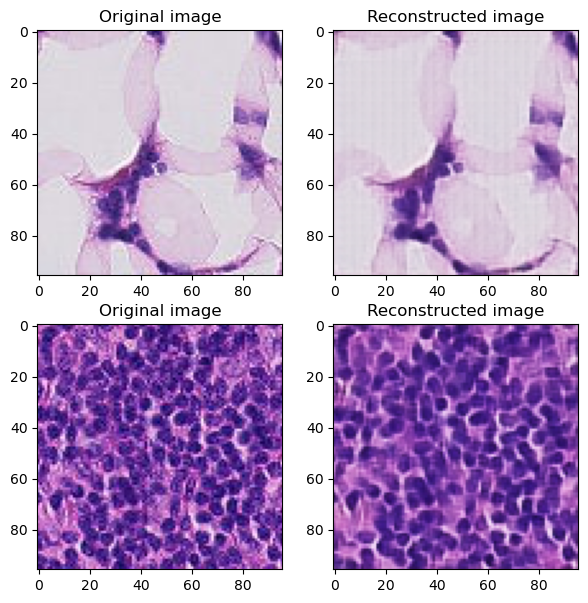

In [130]:
img_batch = train_gen[0][0]
img_batch_fake = train_gen_fake[0][0]
image_nr = 10

fig,ax = plt.subplots(2,2,figsize=(7,7))

ax[0,0].imshow(img_batch[image_nr])
ax[0,0].set_title('Original image')
ax[0,1].imshow(img_batch_fake[image_nr])
ax[0,1].set_title('Reconstructed image')
ax[1,0].imshow(img_batch[image_nr+1])
ax[1,0].set_title('Original image')
ax[1,1].imshow(img_batch_fake[image_nr+1])
ax[1,1].set_title('Reconstructed image');


In [30]:
# FCNN trained with augmented dataset

#train_gen, val_gen = get_pcam_generators('C:/Users/20212238/OneDrive - TU Eindhoven/Documents/TUE/Jaar 3/Project AI MIA', class_mode='binary')


def get_model(kernel_size=(3,3), pool_size=(4,4), first_filters=32, second_filters=64):

     # build the model
     model = Sequential()

     model.add(Conv2D(first_filters, kernel_size, activation = 'relu', padding = 'same', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
     model.add(MaxPool2D(pool_size = pool_size))

     model.add(Conv2D(second_filters, kernel_size, activation = 'relu', padding = 'same'))
     model.add(MaxPool2D(pool_size = pool_size))

     # layers replacing the dense layers (explained in pdf)
     model.add(Conv2D(second_filters, (6,6), activation = 'relu', padding = 'valid'))
     model.add(Conv2D(1, (1,1), activation = 'sigmoid', padding = 'same'))
     model.add(GlobalAveragePooling2D())

     # compile the model
     model.compile(SGD(learning_rate=0.01, momentum=0.95), loss = 'binary_crossentropy', metrics=['accuracy'])

     return model

model = get_model()
# save the model and weights
model_name = 'FCNN_autoencoder'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json)

# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]

# train the model
train_steps = train_gen_fake.n//train_gen_fake.batch_size//10
val_steps = val_gen_fake.n//val_gen_fake.batch_size//10

history = model.fit(train_gen_fake, steps_per_epoch=train_steps,
                    validation_data=val_gen_fake,
                    validation_steps=val_steps,
                    epochs=3,
                    callbacks=callbacks_list)


Epoch 1/3
900/900 [==============================] - ETA: 0s - loss: 0.7106 - accuracy: 0.4622
Epoch 1: val_loss improved from inf to 0.67025, saving model to FCNN_autoencoder_weights.hdf5
900/900 [==============================] - 1369s 2s/step - loss: 0.7106 - accuracy: 0.4622 - val_loss: 0.6703 - val_accuracy: 1.0000
Epoch 2/3
900/900 [==============================] - ETA: 0s - loss: 0.7036 - accuracy: 0.5022
Epoch 2: val_loss did not improve from 0.67025
900/900 [==============================] - 3221s 4s/step - loss: 0.7036 - accuracy: 0.5022 - val_loss: 0.8062 - val_accuracy: 0.0000e+00
Epoch 3/3
900/900 [==============================] - ETA: 0s - loss: 0.7097 - accuracy: 0.4900
Epoch 3: val_loss did not improve from 0.67025
900/900 [==============================] - 5926s 7s/step - loss: 0.7097 - accuracy: 0.4900 - val_loss: 0.8465 - val_accuracy: 0.0000e+00


In [53]:
# Getting labels and predictions on validation set
# val_true = val_gen_fake.classes
# val_probs = model.predict(val_gen_fake, steps=val_steps*10)

# # Calculating false positive rate (fpr), true positive rate (tpr) and AUC
# fpr, tpr, thresholds = roc_curve(val_true, val_probs)
# roc_auc = auc(fpr, tpr)

# # Generate ROC curve
# roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
# roc.plot()

In [ ]:
basedir = 'C:/Users/20212238/OneDrive - TU Eindhoven/Documents/TUE/Jaar 3/Project AI MIA/train+val/train_reconstructed/'
batch_size = len(train_gen_fake[0][0])

for i in range(int(len(train_gen_fake)/2)):
#for i in range(241,1000):
    batch = cv2.convertScaleAbs(train_gen_fake[i][0], alpha=(255.0))
    for j in range(batch_size):
        filename = '/img_train_' + str(i+1) + '_0_' + str(j+1) + '.jpg'
        filepath = basedir + '0' + filename
        #plt.imsave(filepath,val_gen_fake[i][0][j])
        cv2.imwrite(filepath,batch[j])

for i in range(int(len(train_gen_fake)/2), len(train_gen_fake)):
#for i in range(241,1000):
    batch = cv2.convertScaleAbs(train_gen_fake[i][0], alpha=(255.0))
    for j in range(batch_size):
        filename = '/img_train_' + str(i+1) + '_1_' + str(j+1) + '.jpg'
        filepath = basedir + '1' + filename
        #plt.imsave(filepath,val_gen_fake[i][0][j])
        cv2.imwrite(filepath,batch[j])

In [131]:
val_true = val_gen_fake.classes
val_true[7900:8100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [132]:
val_true = train_gen_fake.classes
val_true[71900:72100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [32]:
basedir = 'C:/Users/20212238/OneDrive - TU Eindhoven/Documents/TUE/Jaar 3/Project AI MIA/train+val/valid_reconstructed/0/test.png'
img = cv2.convertScaleAbs(val_gen_fake[0][0], alpha=(255.0))
cv2.imwrite(basedir,img[0])

True